# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# SKlearn 
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Multi-drug use

In [3]:
incidents = pd.read_csv('../data/Aggregated/incidents.csv', )
incidents['Multiple Drugs'] = 0
incidents.loc[incidents['All Drugs'].str.contains(' | ', regex = False), 'Multiple Drugs'] = 1
incidents[incidents['Multiple Drugs'] == 1].shape

(8050, 17)

In [4]:
### fenytanl

incidents['Fentnyl'] = 0
incidents.loc[incidents['All Drugs'].str.contains('FENTANYL', regex = False), 'Fentnyl'] = 1
incidents[incidents['Fentnyl'] == 1].shape

(7255, 18)

In [5]:
incidents['Fentnyl'].value_counts()

0    13342
1     7255
Name: Fentnyl, dtype: int64

In [6]:
incidents.columns

Index(['Incident ID', 'Incident Date', 'Incident Time', 'Day',
       'Incident County Name', 'Incident State', 'Victim ID', 'Gender Desc',
       'Age Range', 'Race', 'Ethnicity Desc', 'Naloxone Administered',
       'Survive', 'Response Desc', 'All Drugs', 'Incident Date ym',
       'Multiple Drugs', 'Fentnyl'],
      dtype='object')

### Year, Month and Age Range

In [7]:
incidents["year"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)
incidents["month"] = incidents['Incident Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').month)

# Fix value typo
incidents["Age Range"] = incidents["Age Range"].apply(lambda x: "10 - 14" if x == "14-Oct" else x)

In [8]:
incidents.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,Ethnicity Desc,Naloxone Administered,Survive,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentnyl,year,month
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,Not Hispanic,1,0,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,Not Hispanic,0,0,None,HEROIN,2018,0,0,2018,1


In [9]:
incidents['Age Range'].value_counts()

30 - 39    7653
25 - 29    4082
40 - 49    3434
20 - 24    2030
50 - 59    1871
60 - 69     634
0 - 9       530
15 - 19     276
70 - 79      70
80 - *       10
10 - 14       7
Name: Age Range, dtype: int64

In [10]:
def agerange_weekend(df):
    for i, row in df.iterrows():
        if row['Day'] == 'Friday' or row['Day'] == 'Saturday' or row['Day'] == 'Sunday':
            df.loc[i,'Weekend_OD'] = 1
        else:
            df.loc[i,'Weekend_OD'] = 0
        
        if row['month'] == 1 or row['month'] == 12 or row['month'] == 2:
            df.loc[i,'Season'] = 'Winter'
        elif row['month'] == 3 or row['month'] == 4 or row['month'] == 5:
            df.loc[i,'Season'] = 'Spring'
        elif row['month'] == 6 or row['month'] == 7 or row['month'] == 8:
            df.loc[i,'Season'] = 'Summer'
        elif row['month'] == 9 or row['month'] == 10 or row['month'] == 11:
            df.loc[i,'Season'] = 'Fall' 
            
        if row['Age Range'] == '0 - 9' or row['Age Range'] == '10 - 14' or row['Age Range'] == '15 - 19' or row['Age Range'] == '20 - 24' or row['Age Range'] == '30 - 39':
            df.loc[i,'Over 40'] = 0
        else:    
        
            df.loc[i,'Over 40'] = 1
            
    return(df)            
                
            
            
            

In [11]:
incidents2 = agerange_weekend(incidents.copy())

In [12]:
incidents2.head(2)

,Incident ID,Incident Date,Incident Time,Day,Incident County Name,Incident State,Victim ID,Gender Desc,Age Range,Race,...,Response Desc,All Drugs,Incident Date ym,Multiple Drugs,Fentnyl,year,month,Weekend_OD,Season,Over 40
0,1,1/4/2018,0:42:00,Thursday,Delaware,Pennsylvania,1,Male,50 - 59,White,...,NO RESPONSE TO NALOXONE,COCAINE/CRACK | HEROIN,2018,1,0,2018,1,0.0,Winter,1.0
1,26,1/26/2018,9:14:00,Friday,Chester,Pennsylvania,5,Male,25 - 29,White,...,None,HEROIN,2018,0,0,2018,1,1.0,Winter,1.0


In [13]:
incidents2[['hour','min','second']] = incidents2['Incident Time'].str.split(':',expand=True)

In [14]:
def hoursplit(df):
    for i, row in df.iterrows():
        if row['hour'] in['1','2','3','4']:
            df.loc[i, 'time_period'] ='late_evening'
        elif row['hour'] in['5','6','7','8','9']: 
            df.loc[i, 'time_period'] ='early_morning'
        elif row['hour'] in['10','11','12','13','14']: 
            df.loc[i, 'time_period'] ='morning_afternoon'  
        elif row['hour'] in['15','16','17','18','19']: 
            df.loc[i, 'time_period'] ='afternoon_even'
        else:
            df.loc[i, 'time_period'] = 'evening'
    return(df)                
            

In [15]:
incidents2 = hoursplit(incidents2.copy())

In [41]:
incidents2['Over 40'] = incidents2['Over 40'].astype(int)
incidents2['Weekend_OD'] = incidents2['Weekend_OD'].astype(int)

In [45]:
df2 = incidents2[['Day','Incident County Name','Gender Desc','Age Range','Race','Naloxone Administered','Multiple Drugs',
                  'year','month','Weekend_OD','Season','Over 40','time_period']]

In [46]:
from sklearn.preprocessing import LabelEncoder

def label_encode_strings(df):
    """
    Label encodes all the string columns in a pandas DataFrame.
    
    Args:
        df (pandas.DataFrame): The DataFrame to label encode.
    
    Returns:
        pandas.DataFrame: The label encoded DataFrame.
    """
    # Create a new DataFrame to hold the label encoded data
    encoded_df = df.copy()

    # Loop over all columns in the DataFrame
    for col in encoded_df.columns:
        if encoded_df[col].dtype == "object":
            # If the column contains strings, use LabelEncoder to encode them
            le = LabelEncoder()
            encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    
    return encoded_df

In [47]:
df4 = label_encode_strings(df2.copy())

In [49]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
selector = SelectKBest(score_func=f_classif, k=10)
X = df4.drop('Naloxone Administered', axis=1)  # remove the target column
y = df4['Naloxone Administered']
X_selected = selector.fit_transform(X, y)


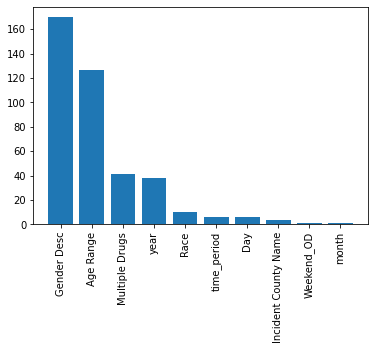

In [54]:
scores = selector.scores_
feature_names = X.columns
sorted_indices = scores.argsort()[::-1][:10]  # get the top 10 feature indices
plt.bar(range(10), scores[sorted_indices])
plt.xticks(range(10), feature_names[sorted_indices], rotation=90)
plt.show()

In [99]:


X = incidents2[['Gender Desc','Age Range','Multiple Drugs','Race','year','time_period','Day','Incident County Name']]
y = incidents2[['Naloxone Administered']]

In [100]:
y['Naloxone Administered'].value_counts()

1    14151
0     6446
Name: Naloxone Administered, dtype: int64

In [101]:
class_weight_m = {0:14151,1:6446}

## Pipeline Definition

In [106]:
##pipeline  
label_features =['Gender Desc','Age Range','Multiple Drugs','Race','time_period','Day','Incident County Name']
label_transformer = OneHotEncoder(sparse = False, handle_unknown = 'ignore')



preprocessor = ColumnTransformer(
    transformers=[
        ('label', label_transformer, label_features)
        ])   


model =  Pipeline(steps=[('preprocessor', preprocessor),
                      ('randomforest', RandomForestClassifier(n_estimators=1000,
                                                              class_weight=class_weight_m))])

In [103]:
# Split data with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [107]:
model.fit(X_train,y_train)


/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('label',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Gender Desc', 'Age Range',
                                                   'Multiple Drugs', 'Race',
                                                   'time_period', 'Day',
                                                   'Incident County Name'])])),
                ('randomforest',
                 RandomForestClassifier(class_weight={0: 14151, 1: 6446},
                                        n_estimators=1000))])

In [97]:
predictions_classweights = model.predict(X_test)
print("accuracy:",accuracy_score(y_test, predictions_classweights))

accuracy: 0.5951456310679611


In [108]:
from sklearn.model_selection import StratifiedKFold
import numpy
kf = StratifiedKFold(n_splits=5,random_state=0, shuffle=True)

 
acc_score = []
pred = []
y_test_all = []
predprob = []
 
for train_index , test_index in kf.split(X,y):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    model.fit(X_train,y_train)
    print(model.score(X_test, y_test))
    num = model.score(X_test, y_test)
    num = num.astype(float)
    acc_score.append(num)
    predictions_classweights = model.predict(X_test)
    proba = model.predict_proba(X_test)
    predprob.append(proba)                           
    
    #predict_class = np.argmax(test_predictions, axis=1)
    #predict_class = predict_class.tolist()
    
    pred.append(predictions_classweights)
    y_test_all.append(y_test)


/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.6410194174757281


/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.6453883495145631


/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.6421461519786356


/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.6455450352027191


/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


0.6314639475600874


In [109]:
pred_master = np.hstack(([pred[0],pred[1],pred[2],pred[3],pred[4]]))
y_test_master = pd.concat(y_test_all)

In [110]:
pr0 = pd.DataFrame(predprob[0],columns=['zero','one'])
pr1 = pd.DataFrame(predprob[1],columns=['zero','one'])
pr2 = pd.DataFrame(predprob[2],columns=['zero','one'])
pr3 = pd.DataFrame(predprob[3],columns=['zero','one'])
pr4 = pd.DataFrame(predprob[4],columns=['zero','one'])

In [111]:
prdf1 = pd.concat([pr0,pr1,pr2,pr3,pr4])
prdf1 = prdf1[['one']]
prdf2 =prdf1.copy()

In [112]:
prdf2['one'] = np.select([prdf2['one']>=.65],  ### setting threshold
                        [1],
                        default=0)

In [113]:
confusion = confusion_matrix(y_test_master,prdf2)

In [114]:
print(confusion)

[[3477 2969]
 [5641 8510]]


In [115]:
target_names = ['Not Given Naloxone', 'Given Naloxone']
print(classification_report(y_test_master, prdf2, target_names=target_names))

                    precision    recall  f1-score   support

Not Given Naloxone       0.38      0.54      0.45      6446
    Given Naloxone       0.74      0.60      0.66     14151

          accuracy                           0.58     20597
         macro avg       0.56      0.57      0.56     20597
      weighted avg       0.63      0.58      0.60     20597



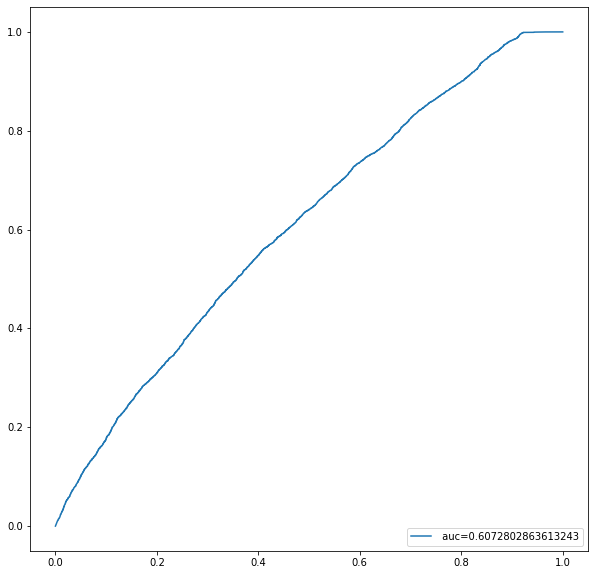

In [89]:
fpr, tpr, _ = metrics.roc_curve(y_test_master,prdf1)
auc = metrics.roc_auc_score(y_test_master,prdf1)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [117]:

#### for gini importance
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

In [118]:
def row_to_dict(x,y=None):
    return X.apply(dict,axis=1)
    
ft = FunctionTransformer(row_to_dict, validate=False)
dv = DictVectorizer()
rf = RandomForestClassifier(n_estimators=1000)

model = make_pipeline(ft,dv,rf)
model.fit(X,y)
feature_importances = zip(dv.feature_names_,rf.feature_importances_)

 



/Users/loganj2/Desktop/Twitter_PKids_collection/twit/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [119]:
dv.feature_names_

['Age Range=0 - 9',
 'Age Range=10 - 14',
 'Age Range=15 - 19',
 'Age Range=20 - 24',
 'Age Range=25 - 29',
 'Age Range=30 - 39',
 'Age Range=40 - 49',
 'Age Range=50 - 59',
 'Age Range=60 - 69',
 'Age Range=70 - 79',
 'Age Range=80 - *',
 'Day=Friday',
 'Day=Monday',
 'Day=Saturday',
 'Day=Sunday',
 'Day=Thursday',
 'Day=Tuesday',
 'Day=Wednesday',
 'Gender Desc=Female',
 'Gender Desc=Male',
 'Gender Desc=Unknown',
 'Incident County Name=Adams',
 'Incident County Name=Allegheny',
 'Incident County Name=Armstrong',
 'Incident County Name=Beaver',
 'Incident County Name=Bedford',
 'Incident County Name=Berks',
 'Incident County Name=Blair',
 'Incident County Name=Bradford',
 'Incident County Name=Bucks',
 'Incident County Name=Butler',
 'Incident County Name=Cambria',
 'Incident County Name=Carbon',
 'Incident County Name=Centre',
 'Incident County Name=Chester',
 'Incident County Name=Clarion',
 'Incident County Name=Clearfield',
 'Incident County Name=Clinton',
 'Incident County Name=

In [146]:

age_range = sum(rf.feature_importances_[0:11])
day = sum(rf.feature_importances_[11:19])
gender = sum(rf.feature_importances_[19:22])
County = sum(rf.feature_importances_[22:87])
multiple_drugs = rf.feature_importances_[87]
race = sum(rf.feature_importances_[88:93])
time_period = sum(rf.feature_importances_[93:98])
year =  rf.feature_importances_[98]


In [147]:
features=['Age_range','Day','Gender','County','Multiple_drugs','Race','Time_period','Year']
importance=[age_range,day,gender,County,multiple_drugs,race,time_period,year]

In [148]:
feats = {}
for feature, importance in zip(features,importance):
    feats[feature] = importance
    

<AxesSubplot:>

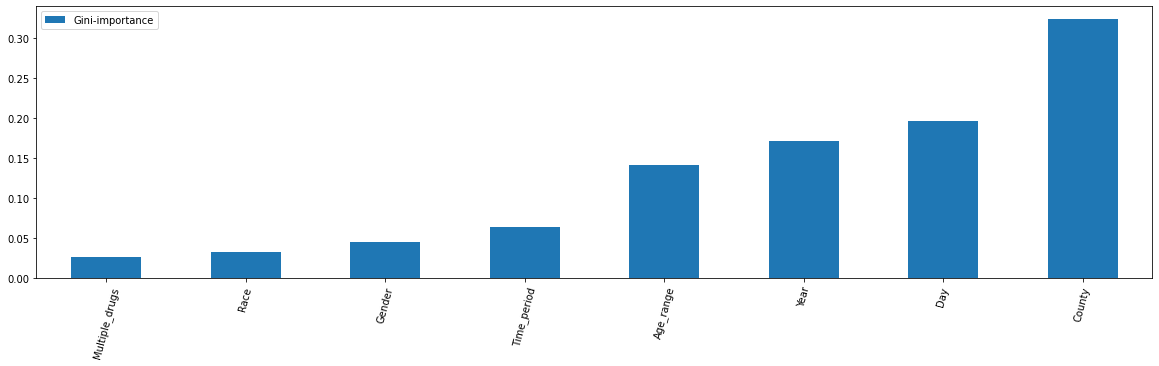

In [149]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=75, figsize =(20,5))